<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/interpolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Explore bottlenecks for interpolation, in terms of the size of input and size of the grid onto which to interpolate

# Setup


In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
import coords

--2021-03-18 00:49:11--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681 (1.6K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   1.64K  --.-KB/s    in 0s      

2021-03-18 00:49:11 (36.6 MB/s) - ‘coords.py’ saved [1681/1681]



In [3]:
import matplotlib.pyplot as plt
def doplt(arr2d): return(plt.imshow(arr2d,cmap='gray'))

# 2D Gaussian

In [140]:
n_values=500
np.random.seed(0)
XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
percentile = np.percentile(np.abs(XY.flatten()),q=95)
good_idx = (np.abs(XY) > percentile).sum(1)==0
abs_max = np.abs(XY[good_idx]).max()
# XY = XY[good_idx]
Z = np.exp(-(XY**2).sum(1)/2)
abs_max

1.9559123082506942

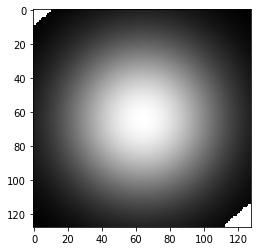

In [141]:
n_grid = 128
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
Z_grid = griddata(points=XY,values=Z,xi=xi_match,method='cubic')

doplt(Z_grid.reshape(n_grid,n_grid))

# $O(?)$ in `len(xi)`

With fixed number of `points` from `XY`, and of course matching fixed number of `values` from `Z`, let's see how the runtime scales with different sized query points `xi`

In [108]:
for n_grid in [64,128,256,512,1024]:
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  %timeit griddata(points=XY,values=Z,xi=xi_match)
Z_grid = griddata(points=XY,values=Z,xi=xi_match)

10 loops, best of 5: 137 ms per loop
10 loops, best of 5: 136 ms per loop
10 loops, best of 5: 140 ms per loop
10 loops, best of 5: 155 ms per loop
1 loop, best of 5: 204 ms per loop


These doesn't seem to be much dependence on the grid size, perhaps a log scale dependence.

# $O(?)$ in `len(values)`

Now with fixed number of query points `xi`, let's see how the runtime scales with different number of `points` from `XY`, and of course matching number of `values` from `Z`.

In [109]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
  percentile = np.percentile(np.abs(XY.flatten()),q=95)
  good_idx = (np.abs(XY) > percentile).sum(1)==0
  abs_max = np.abs(XY[good_idx]).max()
  Z = np.exp(-(XY**2).sum(1)/2)

  n_grid = 64
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  func1_time = %timeit -o griddata(points=XY,values=Z,xi=xi_match,method='linear')
  timings[idx] = func1_time.best

1000 loops, best of 5: 1.59 ms per loop
100 loops, best of 5: 12.8 ms per loop
10 loops, best of 5: 136 ms per loop
1 loop, best of 5: 1.82 s per loop
1 loop, best of 5: 19.7 s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 19.8 us/value ')

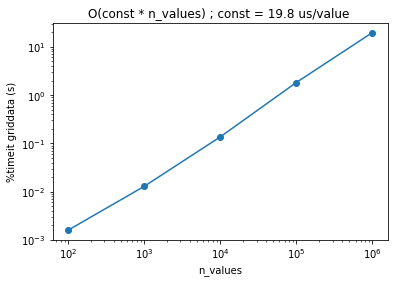

In [110]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-3]) / (n_values_li[-1]-n_values_li[-3])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

For every extra value, griddata will take 24 to 27 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|d|n_grid|%timeit griddata (us/value)|
|-|-|-|
|2|64|26.5 |
|2| 128|25 |
|2|256|24.1|
|2|512|26.6|

# 3D Gaussian

In [111]:
n_values=10**6
d=3
np.random.seed(0)
XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
good_idx = (np.abs(XYZ) > percentile).sum(1)==0
abs_max = np.abs(XYZ[good_idx]).max()
# XY = XY[good_idx]
F = np.exp(-(XYZ**2).sum(1)/2)

abs_max

1.9581565358354729

In [112]:
n_grid = 512
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
F_grid = griddata(points=XYZ,values=F,xi=xi_match)



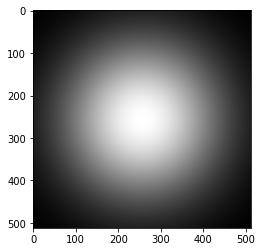

In [113]:
doplt(np.nanmean(F_grid.reshape(n_grid,n_grid,n_grid),0))

The 3D interpolation is working. Let's see how this scales.

In [114]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
  percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
  good_idx = (np.abs(XYZ) > percentile).sum(1)==0
  abs_max = np.abs(XYZ[good_idx]).max()
  F = np.exp(-(XYZ**2).sum(1)/2)

  n_grid = 512
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  griddata_time = %timeit -o griddata(points=XYZ,values=F,xi=xi_match,method='linear')
  timings[idx] = griddata_time.best

1 loop, best of 5: 8.87 s per loop
1 loop, best of 5: 10.8 s per loop
1 loop, best of 5: 12.4 s per loop
1 loop, best of 5: 22.6 s per loop
1 loop, best of 5: 1min 57s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 105.4 us/value ')

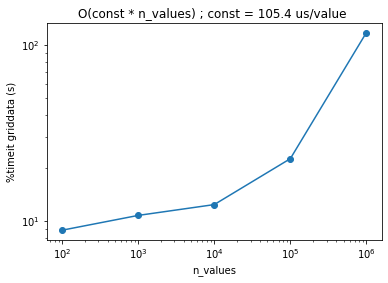

In [130]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-2]) / (n_values_li[-1]-n_values_li[-2])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

In [116]:
timings[-1]/n_values_li[-1]

0.0001174606974060007

For every extra value, griddata will take 100 to 111 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|n_grid|%timeit griddata (us/value)|
|-|-|
| 64|100.5|
| 128| |
|256||
|512|108-111|

We can see now in 3D, the trend is the same, but the constant is larger. There still is practically no dependence on `n_grid`.



# Parralelization

When we are doing Fourier inversion, for a box size of N, and $n_p$ particles we would have $N^2n_p$ (complex) values on an $N^3$ sized grid. For 10k particles and $N \in \{64,126,256,512\}$ this would be \{41,163,655,2621\} million complex numbers to interpolate. Surely something parralelized and fast is doing this, and not griddata, which would take \{1.1,4.6,18,73\} hours.

Parralelization could be leveraged if the interpolated slices can just be added to each other. We could do the interpolations in batches in parallel, and then bring them together at the end. Essentially doing averages step by step.

* https://stackoverflow.com/questions/14015114/scipy-interpolate-griddata-equivalent-in-cuda
* https://dypy.readthedocs.io/en/latest/intergrid.html

# Bicubic interpolation
The section *Bicubic interpolation polynomial* [here](https://www.paulinternet.nl/?page=bicubic) gives the coefficients $a_{ij}$ for 
$$
g(x,y) = \sum_{ij}a_{ij}x^iy^j = a_{00} + a_{10}x + a_{11}xy + ... + a_{32}x^3y^2 + a_{33}x^3y^3 
$$

$a_{ij}$ is given in terms of the "16 points pij, with i and j going from 0 to 3 and with pij located at (i-1, j-1)"

We can hard code this and try out a simple example and compare the function to the bicubic interpolated estimate

Function: a simple gaussian

In [87]:
N=16
xv,yv = np.meshgrid(np.arange(-N//2,N//2),np.arange(-N//2,N//2))

def gauss(x,y,mux=0,muy=0,sigma=4):
  r2 = (x-mux)**2+(y-muy)**2
  g = np.exp(-r2/(2*sigma**2))
  return(g)

sigma=4
f = gauss(xv,yv,sigma=sigma)

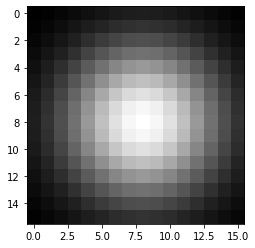

In [80]:
doplt(f)

We are going to interpolate based on the 16 points from the inner 4x4 array 

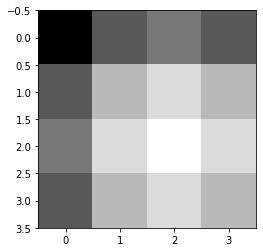

In [65]:
mid=N//2 # 8
p = f[mid-2:mid+2,mid-2:mid+2] # -2,-1,0,1
doplt(p)

In [66]:
xv[mid-2:mid+2,mid-2:mid+2], yv[mid-2:mid+2,mid-2:mid+2]

(array([[-2, -1,  0,  1],
        [-2, -1,  0,  1],
        [-2, -1,  0,  1],
        [-2, -1,  0,  1]]), array([[-2, -2, -2, -2],
        [-1, -1, -1, -1],
        [ 0,  0,  0,  0],
        [ 1,  1,  1,  1]]))

Thankfully I can copy/paste the code from the link

In [97]:
def bicubic_coeff(p):
  a00 = p[1][1];
  a01 = -.5*p[1][0] + .5*p[1][2];
  a02 = p[1][0] - 2.5*p[1][1] + 2*p[1][2] - .5*p[1][3];
  a03 = -.5*p[1][0] + 1.5*p[1][1] - 1.5*p[1][2] + .5*p[1][3];
  a10 = -.5*p[0][1] + .5*p[2][1];
  a11 = .25*p[0][0] - .25*p[0][2] - .25*p[2][0] + .25*p[2][2];
  a12 = -.5*p[0][0] + 1.25*p[0][1] - p[0][2] + .25*p[0][3] + .5*p[2][0] - 1.25*p[2][1] + p[2][2] - .25*p[2][3];
  a13 = .25*p[0][0] - .75*p[0][1] + .75*p[0][2] - .25*p[0][3] - .25*p[2][0] + .75*p[2][1] - .75*p[2][2] + .25*p[2][3];
  a20 = p[0][1] - 2.5*p[1][1] + 2*p[2][1] - .5*p[3][1];
  a21 = -.5*p[0][0] + .5*p[0][2] + 1.25*p[1][0] - 1.25*p[1][2] - p[2][0] + p[2][2] + .25*p[3][0] - .25*p[3][2];
  a22 = p[0][0] - 2.5*p[0][1] + 2*p[0][2] - .5*p[0][3] - 2.5*p[1][0] + 6.25*p[1][1] - 5*p[1][2] + 1.25*p[1][3] + 2*p[2][0] - 5*p[2][1] + 4*p[2][2] - p[2][3] - .5*p[3][0] + 1.25*p[3][1] - p[3][2] + .25*p[3][3];
  a23 = -.5*p[0][0] + 1.5*p[0][1] - 1.5*p[0][2] + .5*p[0][3] + 1.25*p[1][0] - 3.75*p[1][1] + 3.75*p[1][2] - 1.25*p[1][3] - p[2][0] + 3*p[2][1] - 3*p[2][2] + p[2][3] + .25*p[3][0] - .75*p[3][1] + .75*p[3][2] - .25*p[3][3];
  a30 = -.5*p[0][1] + 1.5*p[1][1] - 1.5*p[2][1] + .5*p[3][1];
  a31 = .25*p[0][0] - .25*p[0][2] - .75*p[1][0] + .75*p[1][2] + .75*p[2][0] - .75*p[2][2] - .25*p[3][0] + .25*p[3][2];
  a32 = -.5*p[0][0] + 1.25*p[0][1] - p[0][2] + .25*p[0][3] + 1.5*p[1][0] - 3.75*p[1][1] + 3*p[1][2] - .75*p[1][3] - 1.5*p[2][0] + 3.75*p[2][1] - 3*p[2][2] + .75*p[2][3] + .5*p[3][0] - 1.25*p[3][1] + p[3][2] - .25*p[3][3];
  a33 = .25*p[0][0] - .75*p[0][1] + .75*p[0][2] - .25*p[0][3] - .75*p[1][0] + 2.25*p[1][1] - 2.25*p[1][2] + .75*p[1][3] + .75*p[2][0] - 2.25*p[2][1] + 2.25*p[2][2] - .75*p[2][3] - .25*p[3][0] + .75*p[3][1] - .75*p[3][2] + .25*p[3][3];
  a = np.array([a00,a01,a02,a03,a10,a11,a12,a13,a20,a21,a22,a23,a30,a31,a32,a33])
  return(a00,a01,a02,a03,a10,a11,a12,a13,a20,a21,a22,a23,a30,a31,a32,a33)
a = bicubic_coeff(p)

Now I want to interpolate at many values on $[-2,1] \text{x} [-2,1]$

In [99]:
step_interp = 1
offset=1
vals_interp = np.arange(-2+offset,1+offset+step_interp,step=step_interp) # many points
vals_interp
x, y = np.meshgrid(vals_interp,vals_interp)
x.shape

(4, 4)

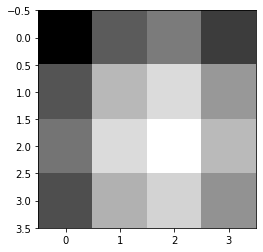

In [100]:
def bicubic_interp(a,x,y):
  x2 = x * x;
  x3 = x2 * x2;
  y2 = y * y;
  y3 = y2 * y;

  g = (a00 + a01 * y + a02 * y2 + a03 * y3) + \
            (a10 + a11 * y + a12 * y2 + a13 * y3) * x + \
            (a20 + a21 * y + a22 * y2 + a23 * y3) * x2 + \
            (a30 + a31 * y + a32 * y2 + a33 * y3) * x3
  return(g)
g = bicubic_interp(a,x,y)
doplt(g)

In [101]:
g

array([[0.78371096, 0.86073811, 0.88806087, 0.83603241],
       [0.85534533, 0.93941306, 0.96923323, 0.91244917],
       [0.8824969 , 0.96923323, 1.        , 0.94141341],
       [0.85043515, 0.93402028, 0.96366927, 0.90721117]])

In [102]:
p

array([[0.77880078, 0.85534533, 0.8824969 , 0.85534533],
       [0.85534533, 0.93941306, 0.96923323, 0.93941306],
       [0.8824969 , 0.96923323, 1.        , 0.96923323],
       [0.85534533, 0.93941306, 0.96923323, 0.93941306]])

Let's try with a finder grid. Note that we do not recomptue the coefficients, just change the points we want to compute the inerpolated function at

In [104]:
step_interp = .1
offset=1
vals_interp = np.arange(-2+offset,1+offset+step_interp,step=step_interp) # many points
vals_interp
x, y = np.meshgrid(vals_interp,vals_interp)
x.shape

(31, 31)

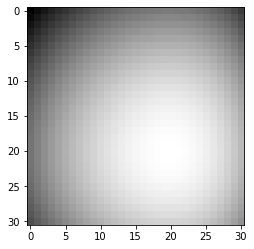

In [105]:
g = bicubic_interp(a,x,y)
doplt(g)

We can compare the interpolated values on this finer grid, with the actual function values (we know the function, it's the gaussian). This will tell us how well bicubic interpolations works for this function, which depends on how fast the gaussian is decaying and how many terms are needed to approx it over the 16 points used in the bicibic interpolation)

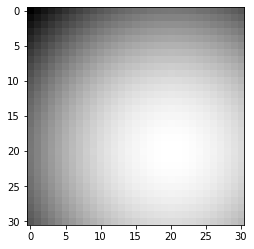

In [94]:
g_fine = gauss(x-offset,y-offset,sigma=sigma)
doplt(g_fine)

Error

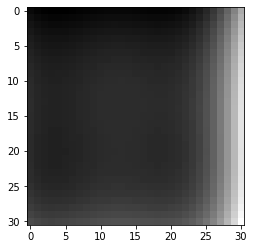

In [95]:
doplt(g_fine-g)

# Source of `scipy.interpolate.griddata`
* https://github.com/scipy/scipy/blob/v1.5.4/scipy/interpolate/interpnd.pyx
  * in linear interpolation qhull is used. a likey bottleneck is computing the convex hull of the points http://media.steampowered.com/apps/valve/2014/DirkGregorius_ImplementingQuickHull.pdf